In [6]:
%matplotlib inline
import os,sys
import numpy as np
from scipy.spatial import Delaunay, ConvexHull

from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
import matplotlib.tri as mtri

import matplotlib.pyplot as plt

import torch
import torch.nn as nn
print(torch.__version__)

from IPython.core.display import display, HTML, clear_output
display(HTML("<style>.container { width:90% !important; }</style>"))

sys.path.append('..')
import pytorchnet, pytorchutils

os.environ['CUDA_VISIBLE_DEVICES'] = '1'

0.4.1


(1000, 2)


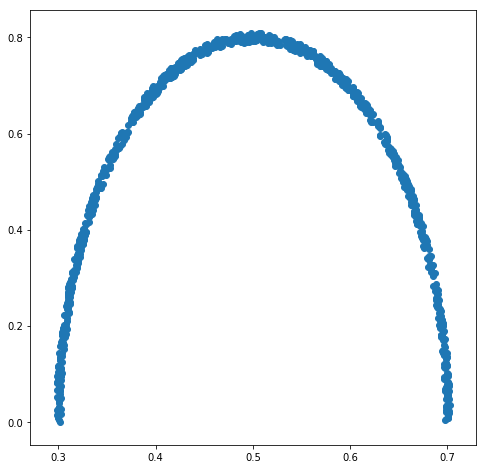

In [2]:
def generateSemicircle(numPoints,meanRadius,radVar):
    theta=np.random.rand(numPoints)*np.pi
    rho=np.random.uniform(-radVar,radVar,(numPoints,))+meanRadius
    return np.stack([np.cos(theta)*rho*0.25+0.5,np.sin(theta)*rho],1)


def generateLine(numPoints,noiseScale):
    m=np.random.rand()*10
    b=np.random.rand()*10
    x=np.linspace(0.1,0.9,numPoints)
    y=(x*m+b)+np.random.normal(scale=noiseScale,size=(numPoints,))
    return np.stack([x,y/(y.max()*1.1)],1)


pts=generateSemicircle(1000,0.8,0.01)
# pts=generateLine(1000,0.05)

print(pts.shape)

fig=plt.figure(figsize=[8,8])
plt.scatter(pts[:,0],pts[:,1])

In [3]:
lvae=pytorchnet.DenseVAE(4,6,3,[10,5],[15,10])
print(lvae)

t=torch.randn(10,4)
d,mu,logvar,z=lvae(t)
print(d.shape,z.shape)

DenseVAE(
  (encode): Sequential(
    (encode_0): Sequential(
      (0): Linear(in_features=4, out_features=10, bias=True)
      (1): Dropout(p=0)
      (2): PReLU(num_parameters=1)
    )
    (encode_1): Sequential(
      (0): Linear(in_features=10, out_features=5, bias=True)
      (1): Dropout(p=0)
      (2): PReLU(num_parameters=1)
    )
  )
  (decode): Sequential(
    (decode0): Sequential(
      (0): Linear(in_features=5, out_features=15, bias=True)
      (1): Dropout(p=0)
      (2): PReLU(num_parameters=1)
    )
    (decode1): Sequential(
      (0): Linear(in_features=15, out_features=10, bias=True)
      (1): Dropout(p=0)
      (2): PReLU(num_parameters=1)
    )
    (final): Linear(in_features=10, out_features=6, bias=True)
  )
  (mu): Linear(in_features=5, out_features=3, bias=True)
  (logvar): Linear(in_features=5, out_features=3, bias=True)
  (decodeL): Linear(in_features=3, out_features=5, bias=True)
)
torch.Size([10, 6]) torch.Size([10, 3])


In [34]:
xt=torch.from_numpy(pts).float()
yt=torch.from_numpy(pts).float()

net=pytorchnet.DenseVAE(xt.shape[1],yt.shape[1],2,[20,20,20],[20,20,20])

# MSE makes sense for regression, adjust beta until L1 loss between pred and yt goes down
loss=pytorchnet.KLDivLoss(torch.nn.MSELoss(),beta=1e-6) 
loss1=torch.nn.L1Loss()
# opt=torch.optim.Adam(net.parameters())

iters=10000
    
for st in pytorchutils.SimpleTrainer(iters,net,loss):
    pred,mu,logvar,z=net(xt)
    lossval=st.loss(pred,yt,mu,logvar)
    l1=loss1(pred,yt)

    if st.step%(iters//10)==0:
        print(st,lossval,l1.item(),z.min().item(),z.max().item())

# for i in range(iters):
#     opt.zero_grad()
#     pred,mu,logvar,z=net(xt)
#     lossval=loss(pred,yt,mu,logvar)
#     l1=loss1(pred,yt)
    
#     lossval.backward()
#     opt.step()
    
#     if i%(iters//10)==0:
#         print(i,lossval.item(),l1.item(),z.min().item(),z.max().item())

Trainer(Step: 1000, Loss: 0.003711) 0.0037109116092324257 0.01963370107114315 -2.382141590118408 2.4182472229003906
Trainer(Step: 2000, Loss: 0.003576) 0.0035758663434535265 0.018196456134319305 -2.1612629890441895 2.4816153049468994
Trainer(Step: 3000, Loss: 0.003499) 0.0034993113949894905 0.01776636578142643 -2.056905508041382 2.298769950866699
Trainer(Step: 4000, Loss: 0.003490) 0.003489804919809103 0.01767081953585148 -2.5532784461975098 2.618583917617798
Trainer(Step: 5000, Loss: 0.003426) 0.00342608243227005 0.016653206199407578 -2.4381189346313477 2.569702625274658
Trainer(Step: 6000, Loss: 0.003457) 0.003457264509052038 0.017629234120249748 -2.34045672416687 2.701333999633789
Trainer(Step: 7000, Loss: 0.003432) 0.0034322994761168957 0.01611124724149704 -2.6919851303100586 2.4789042472839355
Trainer(Step: 8000, Loss: 0.003403) 0.003402650821954012 0.01627315767109394 -2.7386202812194824 2.5549912452697754
Trainer(Step: 9000, Loss: 0.003411) 0.0034114017616957426 0.01661634631454

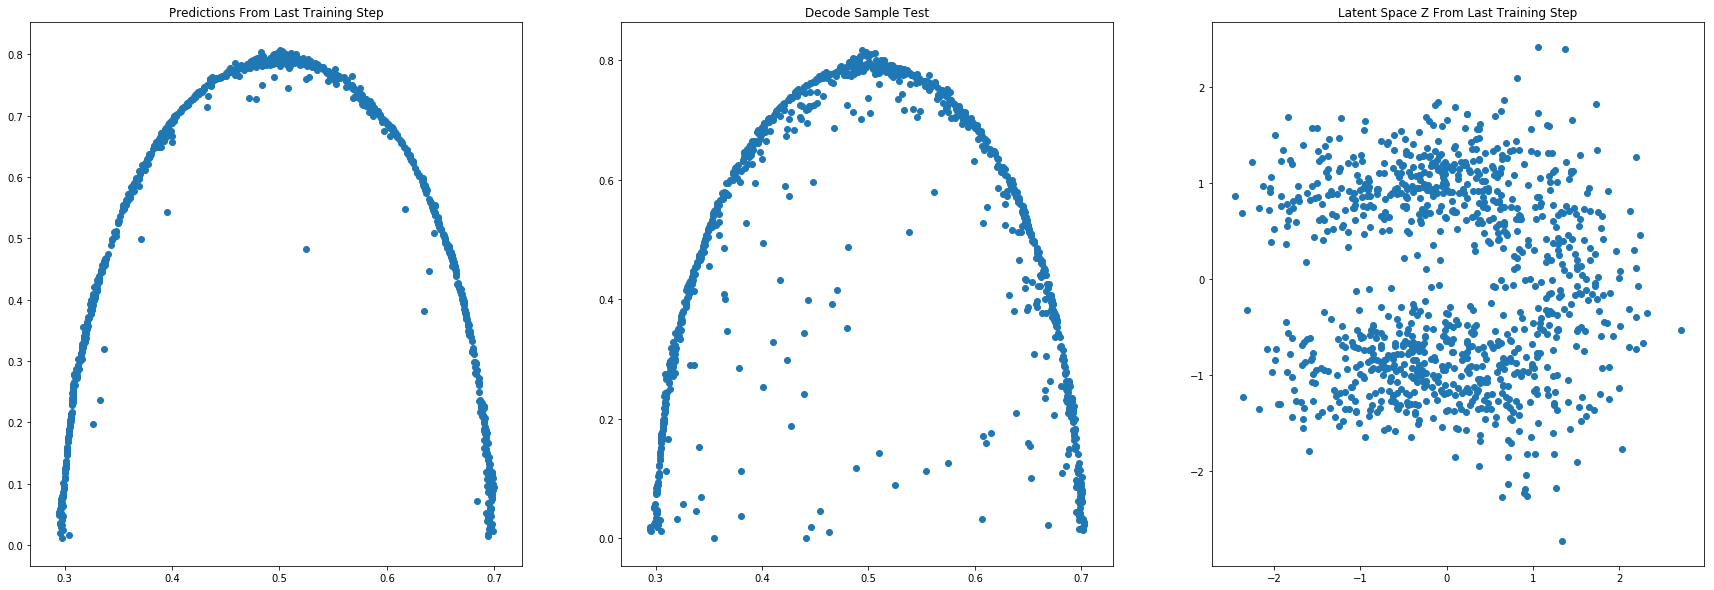

In [35]:
with torch.no_grad():
    net.eval()
    xtest=torch.zeros((1000,2),dtype=torch.float32).normal_(0,1)
    test=net.decodeForward(xtest)

fig,axes=plt.subplots(1,3,figsize=[30,10])
axes[0].scatter(pred[:,0].tolist(),pred[:,1].tolist())
axes[0].set_title('Predictions From Last Training Step')

axes[1].scatter(test[:,0].tolist(),test[:,1].tolist())
axes[1].set_title('Decode Sample Test')

axes[2].scatter(z[:,0].tolist(),z[:,1].tolist())
axes[2].set_title('Latent Space Z From Last Training Step');

In [49]:
def getXi(v,vertices):
    v=v-vertices[0]
    m=vertices[1:]-vertices[0]
    return v.T@np.linalg.inv(m)


def nSimplexCoeffs(xi):
    xi=np.atleast_1d(xi)
    d=xi.shape[0]
    
    return np.atleast_1d([1.0-np.sum(xi)]+xi.tolist())


def nSimplexEval(xi,values):
    return np.sum(np.atleast_1d(values)*nSimplexCoeffs(xi))


def nearestIndex(pt,points):
    return np.argmin(np.sum((points-pt)**2,1)**0.5)


def interpLatents(zverts,delauneyz,values):
    out=[]
    
    for i in range(zverts.shape[0]):
        v=zverts[i]
        sindex=delauneyz.find_simplex(v) # find simplex this latent coord is in
        
        if sindex==-1:
            p=values[nearestIndex(v,delauneyz.points)] # not in a simplex, take nearest vertex's value
        else:
            sinds=delauneyz.simplices[sindex] # simplex vertex indices
            sverts=delauneyz.points[sinds] # simplex vertex coordinates
            svalues=values[sinds] # simplex vertex values

            xi=getXi(v,sverts) # get the xi value of coord in simplex

            if not (np.all(0<=xi) and np.all(xi<=1)) or not (0<=np.sum(xi)<=1):
                print('Bad xi:',xi,i,sindex)
                p=np.mean(svalues)
            else:
                p=nSimplexEval(xi,svalues) # interpolate value
            
        out.append(p)
        
    return np.asarray(out)

In [2]:
boston=np.load('../data/boston.npz')
bdata=boston['data']

np.random.shuffle(bdata)

bdatamax=bdata.max(0)
bdatamin=bdata.min(0)

bdata=(bdata-bdatamin)/(bdatamax-bdatamin)
btest=bdata[:50]
btrain=bdata[50:]

inds=sorted(range(btest.shape[0]),key=lambda i:btest[i,-1])
btest=btest[inds] # sort the test in ascending price order, looks better for graphing

print(btrain.shape,btest.shape,bdatamax,bdatamin)

(456, 14) (50, 14) [ 88.9762 100.      27.74     1.       0.871    8.78   100.      12.1265
  24.     711.      22.     396.9     37.97    50.    ] [6.3200e-03 0.0000e+00 4.6000e-01 0.0000e+00 3.8500e-01 3.5610e+00
 2.9000e+00 1.1296e+00 1.0000e+00 1.8700e+02 1.2600e+01 3.2000e-01
 1.7300e+00 5.0000e+00]


In [45]:
xt=torch.from_numpy(btrain[:,:-1]).float()

net=pytorchnet.DenseVAE(xt.shape[1],xt.shape[1],2,[200,200,200],[200,200,200])

testloss=torch.nn.L1Loss()
loss=pytorchnet.KLDivLoss(torch.nn.L1Loss(),beta=1e-6) 

opt=torch.optim.Adam(net.parameters())

iters=100000

for st in pytorchutils.SimpleTrainer(iters,net,loss):
    pred,mu,logvar,z=net(xt)
    lossval=st.loss(pred,xt,mu,logvar)
    l1=testloss(pred,xt)

    if st.step%(iters//10)==0:
        print(st,l1.item(),z.min().item(),z.max().item())

Trainer(Step: 10000, Loss: 0.022346) 0.022345956414937973 0.018072225153446198 -3.904853343963623 4.237335681915283
Trainer(Step: 20000, Loss: 0.017676) 0.017676204442977905 0.013370022177696228 -3.3942019939422607 3.6751632690429688
Trainer(Step: 30000, Loss: 0.015000) 0.015000305138528347 0.010685586370527744 -3.2872142791748047 3.4281537532806396
Trainer(Step: 40000, Loss: 0.014376) 0.014375703409314156 0.01010600570589304 -2.9902777671813965 3.171755075454712
Trainer(Step: 50000, Loss: 0.013348) 0.013348355889320374 0.009180739521980286 -2.9276695251464844 3.1182360649108887
Trainer(Step: 60000, Loss: 0.012539) 0.012538788840174675 0.008372598327696323 -2.988848924636841 2.9547457695007324
Trainer(Step: 70000, Loss: 0.012365) 0.01236491184681654 0.008329825475811958 -2.9033119678497314 2.9646995067596436
Trainer(Step: 80000, Loss: 0.012200) 0.012199792079627514 0.00819807592779398 -3.0732967853546143 2.9314799308776855
Trainer(Step: 90000, Loss: 0.011794) 0.011794336140155792 0.007

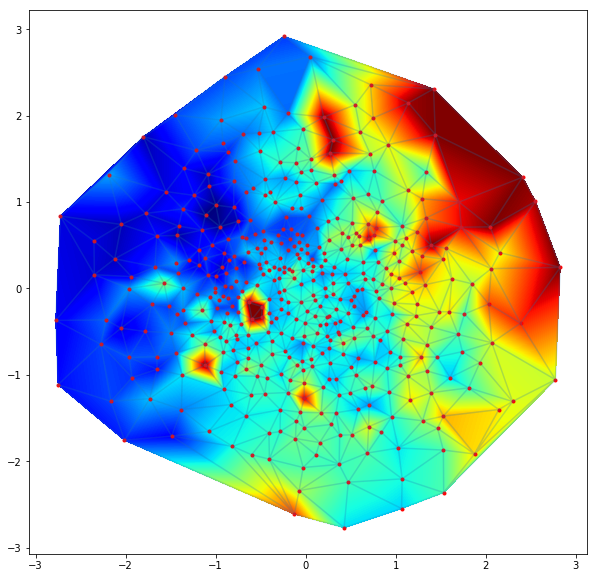

In [46]:
zpts=z.cpu().data.numpy()
zi=z.cpu().data.numpy()

dz=Delaunay(zpts)

fig, ax = plt.subplots(figsize=[10,10])

tri=mtri.Triangulation(zpts[:,0],zpts[:,1],dz.simplices)

# interp = mtri.CubicTriInterpolator(tri,btrain[:,-1])
# zmin,zmax=z.min().item(),z.max().item()
# xi, yi = np.meshgrid(np.linspace(zmin,zmax, 1000), np.linspace(zmin,zmax, 1000))
# zi = interp(xi, yi)
# ax.contourf(xi, yi, zi,cmap='jet',levels=np.linspace(zi.min(),zi.max(),50))

ax.tricontourf(tri,btrain[:,-1],cmap='jet',levels=np.linspace(btrain[:,-1].min(),btrain[:,-1].max()+1e-10,1000))
ax.scatter(zpts[:,0],zpts[:,1],c='r',marker='.')
ax.triplot(zpts[:,0],zpts[:,1],dz.simplices,alpha=0.25)

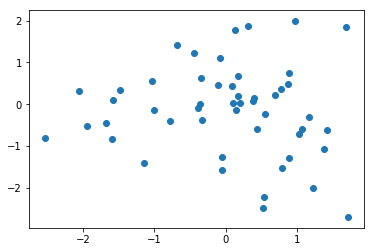

In [47]:
with torch.no_grad():
    net.eval()
    testx=torch.from_numpy(btest[:,:-1]).float().to(xt.device)
    mu,logvar=net.encodeForward(testx)
    testz=net.reparameterize(mu,logvar)
    testz=testz.cpu().data.numpy()
    
plt.scatter(testz[:,0],testz[:,1])

Rescaled average error: 8.704978403028074


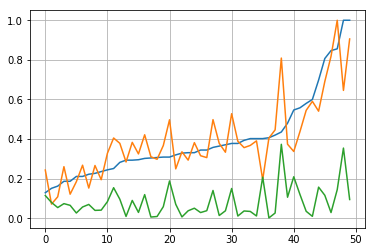

In [50]:
predprices=interpLatents(testz,dz,btrain[:,-1])
#print(np.abs(btest[:,-1]-predprices).mean())
print('Rescaled average error:',(np.abs(btest[:,-1]-predprices)*(bdatamax[-1]-bdatamin[-1])+bdatamin[-1]).mean())

plt.grid(True)
plt.plot(btest[:,-1])
plt.plot(predprices)
plt.plot(np.abs(btest[:,-1]-predprices))

In [53]:
xt=torch.from_numpy(btrain[:,:-1]).float()

net=pytorchnet.DenseVAE(xt.shape[1],xt.shape[1],1,[200,200,200],[200,200,200])

testloss=torch.nn.L1Loss()
loss=pytorchnet.KLDivLoss(torch.nn.L1Loss(),beta=1e-6) 

opt=torch.optim.Adam(net.parameters())

iters=100000

for st in pytorchutils.SimpleTrainer(iters,net,loss):
    pred,mu,logvar,z=net(xt)
    lossval=st.loss(pred,xt,mu,logvar)
    l1=testloss(pred,xt)

    if st.step%(iters//10)==0:
        print(st,l1.item(),z.min().item(),z.max().item())

Trainer(Step: 10000, Loss: 0.039263) 0.036553677171468735 -5.233775615692139 4.040215969085693
Trainer(Step: 20000, Loss: 0.034385) 0.03149617835879326 -5.271985054016113 4.351010799407959
Trainer(Step: 30000, Loss: 0.030118) 0.027073532342910767 -5.301212310791016 4.796217918395996
Trainer(Step: 40000, Loss: 0.027855) 0.02471030317246914 -5.305583477020264 4.798467636108398
Trainer(Step: 50000, Loss: 0.026208) 0.02304965630173683 -5.281533718109131 4.652824878692627
Trainer(Step: 60000, Loss: 0.024417) 0.02123541757464409 -5.236306190490723 4.625836372375488
Trainer(Step: 70000, Loss: 0.024982) 0.02176462672650814 -5.152047634124756 4.6787109375
Trainer(Step: 80000, Loss: 0.022362) 0.01912068948149681 -5.190608024597168 4.719902038574219
Trainer(Step: 90000, Loss: 0.021528) 0.018255356699228287 -5.182662010192871 4.694482803344727
Trainer(Step: 100000, Loss: 0.020588) 0.017315542325377464 -5.075368881225586 4.6267242431640625


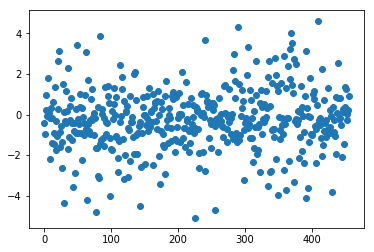

In [54]:
plt.scatter(np.arange(z.shape[0]),z.cpu().data.numpy().flatten())

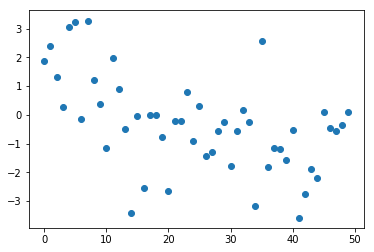

In [55]:
with torch.no_grad():
    net.eval()
    testx=torch.from_numpy(btest[:,:-1]).float().to(xt.device)
    mu,logvar=net.encodeForward(testx)
    testz=net.reparameterize(mu,logvar)
    testz=testz.cpu().data.numpy()
    
plt.scatter(np.arange(testz.shape[0]),testz[:,0])

Rescaled average error: 10.147142823278905


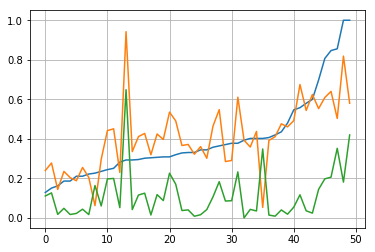

In [58]:
def interpLatents1D(interpz,trainz,values):
    out=[]
    
    for i in range(interpz.shape[0]):
        x=interpz[i]
        nearest=np.argmin(np.abs(trainz-x))
        if nearest==0 and x<trainz[0]:
            return values[0]
        elif nearest==trainz.shape[0]-1 and z>trainz[-1]:
            return values[-1]
        
        nearz=trainz[nearest]
        if x>nearz:
            nextz=trainz[nearest+1]
            xi=(x-nearz)/(nextz-nearz)
            v1=values[nearest]
            v2=values[nearest+1]
        else:
            prevz=trainz[nearest-1]
            xi=(x-prevz)/(nearz-prevz)
            v1=values[nearest-1]
            v2=values[nearest]
        
        out.append((v1*xi)+v2*(1.0-xi))
        
    return np.asarray(out).flatten()

zi=z.cpu().data.numpy().flatten()
sortinds=sorted(list(range(zi.shape[0])),key=lambda i:zi[i])
zisorted=zi[sortinds]
btrainsorted=btrain[sortinds,-1]

predprices=interpLatents1D(testz,zisorted,btrainsorted)
print('Rescaled average error:',(np.abs(btest[:,-1]-predprices)*(bdatamax[-1]-bdatamin[-1])+bdatamin[-1]).mean())
plt.grid(True)
plt.plot(btest[:,-1])
plt.plot(predprices)
plt.plot(np.abs(btest[:,-1]-predprices))

In [59]:
xt=torch.from_numpy(btrain[:,:-1]).float()

net=pytorchnet.DenseVAE(xt.shape[1],xt.shape[1],8,[200,200,200],[200,200,200])

testloss=torch.nn.L1Loss()
loss=pytorchnet.KLDivLoss(torch.nn.L1Loss(),beta=1e-6) 

iters=100000

for st in pytorchutils.SimpleTrainer(iters,net,loss):
    pred,mu,logvar,z=net(xt)
    lossval=st.loss(pred,xt,mu,logvar)
    l1=testloss(pred,xt)

    if st.step%(iters//10)==0:
        print(st,lossval,l1.item(),z.min().item(),z.max().item())

Trainer(Step: 10000, Loss: 0.016159) 0.01615886390209198 0.010094024240970612 -3.2417378425598145 3.479400396347046
Trainer(Step: 20000, Loss: 0.013734) 0.013734301552176476 0.008032766170799732 -3.233957529067993 3.9069015979766846
Trainer(Step: 30000, Loss: 0.012886) 0.012886171229183674 0.007736576721072197 -3.0066285133361816 3.1391916275024414
Trainer(Step: 40000, Loss: 0.012295) 0.012295464053750038 0.007361960131675005 -3.4481687545776367 3.4141595363616943
Trainer(Step: 50000, Loss: 0.011908) 0.011907907202839851 0.0071068755351006985 -3.4408118724823 3.347324848175049
Trainer(Step: 60000, Loss: 0.011730) 0.011730439960956573 0.00701553700491786 -3.9493062496185303 3.272563934326172
Trainer(Step: 70000, Loss: 0.011325) 0.011325335130095482 0.006725132465362549 -3.2838220596313477 2.9388020038604736
Trainer(Step: 80000, Loss: 0.011129) 0.011128806509077549 0.006610260345041752 -2.907960891723633 3.79225754737854
Trainer(Step: 90000, Loss: 0.010969) 0.010969093069434166 0.0064621

In [60]:
with torch.no_grad():
    net.eval()
    testx=torch.from_numpy(btest[:,:-1]).float().to(xt.device)
    mu,logvar=net.encodeForward(testx)
    testz=net.reparameterize(mu,logvar)
    testz=testz.cpu().data.numpy()

In [61]:
print(z.shape)
zi=z.cpu().data.numpy()
dn=Delaunay(zi)

torch.Size([456, 8])


Rescaled average error: 9.376317283083878


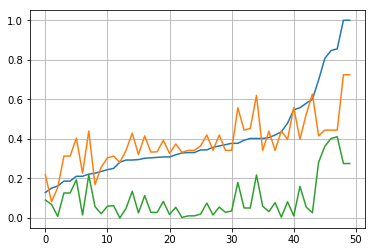

In [62]:
predprices=interpLatents(testz,dn,btrain[:,-1])
print('Rescaled average error:',(np.abs(btest[:,-1]-predprices)*(bdatamax[-1]-bdatamin[-1])+bdatamin[-1]).mean())
plt.grid(True)
plt.plot(btest[:,-1])
plt.plot(predprices)
plt.plot(np.abs(btest[:,-1]-predprices))

In [63]:
xt=torch.from_numpy(btrain).float()

gennet=pytorchnet.DenseVAE(xt.shape[1],xt.shape[1],20,[200,200,200],[200,200,200])

testloss=torch.nn.L1Loss()
loss=pytorchnet.KLDivLoss(torch.nn.L1Loss(),beta=1e-6) 

iters=100000

for st in pytorchutils.SimpleTrainer(iters,gennet,loss):
    pred,mu,logvar,z=gennet(xt)
    lossval=st.loss(pred,xt,mu,logvar)
    l1=testloss(pred,xt)

    if st.step%(iters//10)==0:
        print(st,lossval,l1.item(),z.min().item(),z.max().item())

Trainer(Step: 10000, Loss: 0.015783) 0.015782903879880905 0.009517138823866844 -3.4799623489379883 3.6966381072998047
Trainer(Step: 20000, Loss: 0.014204) 0.014203591272234917 0.008451176807284355 -3.5331599712371826 3.6449661254882812
Trainer(Step: 30000, Loss: 0.013315) 0.013315493240952492 0.00791404489427805 -3.7783422470092773 3.562692165374756
Trainer(Step: 40000, Loss: 0.012871) 0.012870949693024158 0.007842986844480038 -3.6831653118133545 3.6610984802246094
Trainer(Step: 50000, Loss: 0.012230) 0.012229837477207184 0.007293047849088907 -3.8655548095703125 3.710221529006958
Trainer(Step: 60000, Loss: 0.012010) 0.012009715661406517 0.00725752767175436 -3.52219820022583 3.7222652435302734
Trainer(Step: 70000, Loss: 0.011857) 0.01185670681297779 0.007074994966387749 -4.240345478057861 3.691749095916748
Trainer(Step: 80000, Loss: 0.011611) 0.01161099597811699 0.006998068653047085 -4.302171230316162 3.3833794593811035
Trainer(Step: 90000, Loss: 0.011609) 0.011609161272644997 0.0070085

In [ ]:
zrange=z.abs().max().item()

renet=pytorchnet.DenseNet(btrain.shape[1]-1,1,[100,50,20],0.05)
renet.apply(pytorchnet.normalInit)

loss=torch.nn.MSELoss()

iters=100000
losses=[]

gennet.eval()

for st in pytorchutils.SimpleTrainer(iters,renet,loss):
    with torch.no_grad():
        xt=gennet.decodeForward(torch.randn((1000,20))*zrange)
        
    prices=renet(xt[:,:-1])
    st.loss(prices,xt[:,-1:])
    
    losses.append(st.lossval.item())
    
    if st.step%(iters//10)==0:
        print(st)
        
plt.semilogy(losses)

Rescaled average error: 7.585412355124951


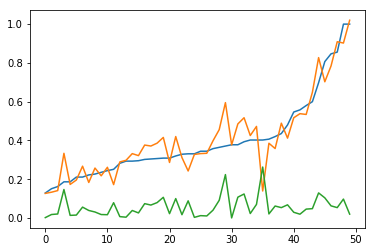

In [90]:
with torch.no_grad():
    renet.eval()
    testxt=torch.from_numpy(btest[:,:-1]).float()
    testprices=renet(testxt).data.numpy()

print('Rescaled average error:',(np.abs(btest[:,-1]-testprices[:,0])*(bdatamax[-1]-bdatamin[-1])+bdatamin[-1]).mean())
plt.plot(btest[:,-1])
plt.plot(testprices[:,0])
plt.plot(np.abs(btest[:,-1]-testprices[:,0]))